# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [1]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])
    print(workingdir)
    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import itertools
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import _pickle as cPickle
import lime
from lime import lime_image
from random import sample, randint, shuffle
import time
import shutil
import glob
import re
import os
import codecs
import json 
import subprocess
import requests
import google.auth

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


### Import our utils functions

In [4]:
import src.utils.mnist_utils as mnist_utils
import src.utils.ml_utils as ml_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_v1.trainer.model as mnist_v1

Current Working direcotory:	/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [5]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(ml_utils)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [6]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [7]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [8]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

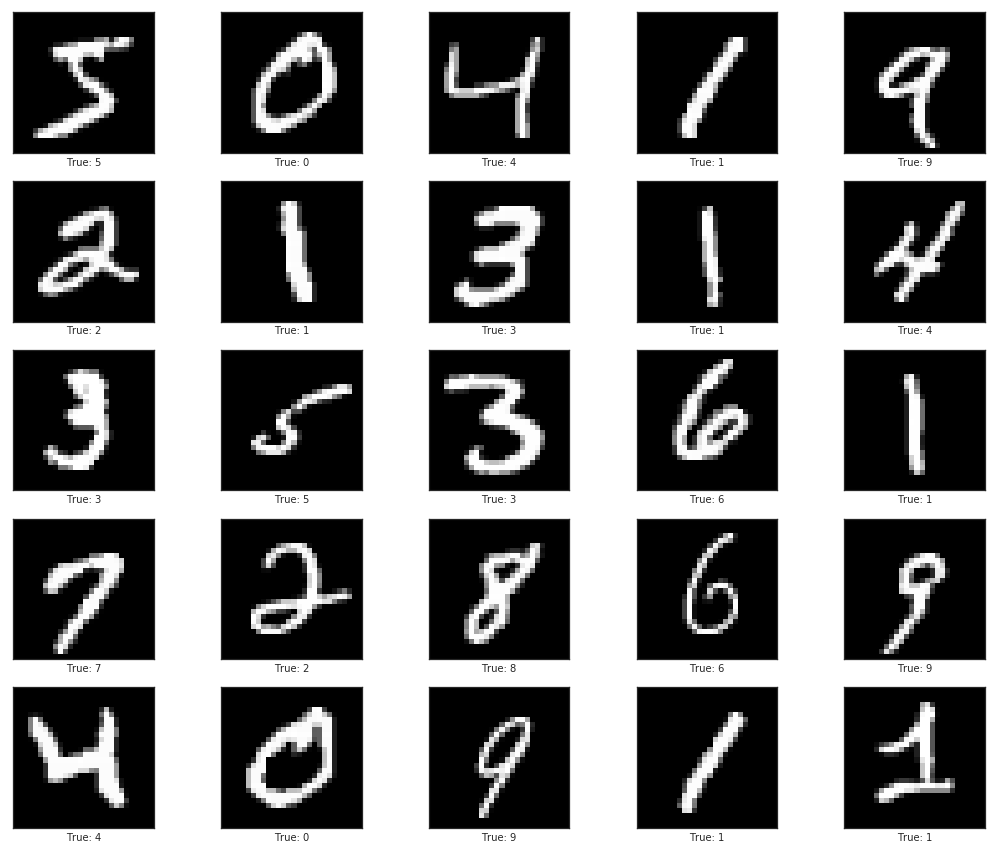

In [9]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [10]:
tf.logging.set_verbosity(tf.logging.INFO)

In [11]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 100

# number of step to train our model
STEPS = 1000

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model name
MODEL_NAME='model_mnist_v1'

# Model Version
MODEL_VERSION = 'v1'

# GCP project name, will be extracted later
PROJECT = ''

# Name of the bucket
BUCKET = 'cloud-training-demos-ml'

# GCP region
REGION = 'us-central1'

# GCP Scale Tier
TIER = 'BASIC'

# Training Directory name
TRAINING_DIR = 'mnist_trained'

# TensforFlow Version
TF_VERSION = '1.12'

# Labels
RESOURCE_LABELS='team=machine-learning,phase=test,owner=fabien'

In [12]:
os.environ['PROJECT'] = subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['BUCKET'] = os.environ['PROJECT']
os.environ['REGION'] = REGION
os.environ['TIER'] = TIER
os.environ['MODEL_NAME'] = MODEL_NAME
os.environ['MODEL_VERSION'] = MODEL_VERSION
os.environ['TRAINING_DIR'] = TRAINING_DIR 
os.environ['TFVERSION'] = TF_VERSION
os.environ['RESOURCE_LABELS'] = RESOURCE_LABELS

## Input dataset
Use tf.data.dataset to feed the Keras model

In [13]:
# be sure you have the tfrecords file locally if you want to train localy (or get them from Cloud Storage)
path_test_tfrecords = 'data/mnist/tfrecords_image_test/*'
path_train_tfrecords = 'data/mnist/tfrecords_image_train/*'

## Defined flags

In [14]:
tensorflow_helper.del_all_flags(tf.flags.FLAGS)

In [15]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('f', '', 'kernel') 

# path to input data
tf.app.flags.DEFINE_string('input_train_tfrecords', path_train_tfrecords, 'input folder of tfrecords training data')
tf.app.flags.DEFINE_string('input_test_tfrecords', path_test_tfrecords, 'input folder of tfrecords testing data')


# path to store the model and input for Tensorboard and SavedModel
tf.app.flags.DEFINE_string('model_dir', 'results/Models/Mnist/tf_1_12/estimator/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', 'results/Models/Mnist/tf_1_12/estimator/pt/', 'Dir to save a model for TF serving')

# parameters for the input dataset and train the model
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('step', STEPS, 'number of step')
tf.app.flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
tf.app.flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
tf.app.flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = tf.app.flags.FLAGS

In [16]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --dim_input: dimension of the input data for our model
    (default: '784')
    (an integer)
  --epoch: number of epoch
    (default: '100')
    (an integer)
  --f: kernel
    (default: '')
  --input_test_tfrecords: input folder of tfrecords testing data
    (default: 'data/mnist/tfrecords_image_test/*')
  --input_train_tfrecords: input folder of tfrecords training data
    (default: 'data/mnist/tfrecords_image_train/*')
  --model_dir: Dir to save a model and checkpoints
    (default: 'results/Models/Mnist/tf_1_12/estimator/ckpt/')
  --num_classes: number of classes in our model
    (default: '10')
    (an integer)
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '-1')
    (an integer)
  --saved_dir: Dir to save a model for TF servin

In [46]:
# pre defined flags
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

### Printing the number relater to the number of events (epoch, batch size, ...)

In [47]:
def print_summary_input(data, step='training'):
    print('Summary for the {} dataset:'.format(step))
    if step=='training':
        print('  - number of epoch            :', FLAGS.epoch)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', FLAGS.batch_size)
        print('  - number of step per epoch   :', FLAGS.step_per_epoch)
        print('  - total number of steps      :', FLAGS.epoch * FLAGS.step_per_epoch)
    else:
        print('  - number of epoch            :', 1)
        print('  - number of events per epoch :', len(data))
        print('  - batch size                 :', None)
        print('  - number of step per epoch   :', 1)
        print('  - total number of steps      :', 1)  

In [48]:
print_summary_input(x_train)

Summary for the training dataset:
  - number of epoch            : 100
  - number of events per epoch : 60000
  - batch size                 : 128
  - number of step per epoch   : 468
  - total number of steps      : 46800


In [49]:
print_summary_input(x_test, 'testing')

Summary for the testing dataset:
  - number of epoch            : 1
  - number of events per epoch : 10000
  - batch size                 : None
  - number of step per epoch   : 1
  - total number of steps      : 1


## Machine Learning modelling with Keras

### Deleting existing models
delete fist the folder for a clean start

In [54]:
print('trained model will be saved here:\n', FLAGS.model_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [51]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [55]:
print('trained model will be saved here:\n', FLAGS.saved_dir)

trained model will be saved here:
 results/Models/Mnist/tf_1_12/estimator/pt/


In [56]:
# deleting the folder from previous try 
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

### Build the model

In [57]:
# reset the model
tf.keras.backend.clear_session()

In [58]:
# build the model
model_opt_tf = mnist_v1.keras_baseline_model(FLAGS.dim_input, FLAGS.num_classes, opt='tf')

# store the origina weights
initial_weights = model_opt_tf.get_weights()

keras_baseline_model


### Check the nuber of parameters

In [59]:
model_opt_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [60]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [61]:
model_opt_tf.output_names

['dense_2']

### Use tf.distribute.startegy work across multiple devices/machines

In [62]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines

#strategy=None
## work with Keras with tf.train optimiser not tf.keras
#NUM_GPUS = 2
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
strategy = tf.contrib.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=1,
                                         save_checkpoints_steps=100,
                                         keep_checkpoint_max=3,
                                         log_step_count_steps=10)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


### Transform a keras model to estimator model

In [63]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 1, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': <tensorflow.contrib.distribute.python.mirrored_strategy.MirroredStrategy object at 0x1c95ba4d68>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c979ef048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distribute_coo

## Training and inference using  tf.estimator and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Create some helper function

In [64]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [65]:
time_hist = TimeHistory()

Input dataset functions for training and testing will be pass during fit to load, convert, preprocess and reshuffle the images and labels 

### Train the  keras to estimator model locally

In [66]:
# drop all files except the keras folder before training
for x in glob.glob(FLAGS.model_dir+'*') :
    if 'keras' not in x:
        os.remove(x)

In [67]:
 for x in glob.glob(FLAGS.model_dir+'*') :
        print(x)

results/Models/Mnist/tf_1_12/estimator/ckpt/keras


In [68]:
%%time
# need if file are removed with previous event files
tf.summary.FileWriterCache.clear()

# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_train_tfrecords+'*',
                                                                                     FLAGS,
                                                                                     mode=tf.estimator.ModeKeys.TRAIN,
                                                                                     batch_size=FLAGS.batch_size),
                            steps=1000),
                            #hooks=[time_hist])

INFO:tensorflow:input_dataset_fn: TRAIN, train
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense/kernel; prev_var_name: Unchanged
DEBUG:tensorflow:Initialize variable dense/kernel:0 from checkpoint results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt with dense/kernel
INFO:tensorflow:Warm-starting variable: dense/bias; prev_var_name: Unchanged
DEBUG:tensorflow:Initialize variable dense/bias:0 from checkpoint results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt with dense/bias
INFO:tensorflow:Warm-starting variable: dense_1/kernel; prev_var_n

INFO:tensorflow:global_step/sec: 35.852
INFO:tensorflow:loss = 0.17666239, step = 560 (0.279 sec)
INFO:tensorflow:global_step/sec: 34.937
INFO:tensorflow:loss = 0.29861853, step = 570 (0.288 sec)
INFO:tensorflow:global_step/sec: 32.0303
INFO:tensorflow:loss = 0.10963169, step = 580 (0.310 sec)
INFO:tensorflow:global_step/sec: 35.6384
INFO:tensorflow:loss = 0.36324126, step = 590 (0.281 sec)
INFO:tensorflow:Saving checkpoints for 600 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 23.637
INFO:tensorflow:loss = 0.13105765, step = 600 (0.423 sec)
INFO:tensorflow:global_step/sec: 46.7827
INFO:tensorflow:loss = 0.24719507, step = 610 (0.215 sec)
INFO:tensorflow:global_step/sec: 36.9434
INFO:tensorflow:loss = 0.17896926, step = 620 (0.270 sec)
INFO:tensorflow:global_step/sec: 37.2962
INFO:tensorflow:loss = 0.36535984, step = 630 (0.268 sec)
INFO:tensorflow:global_step/sec: 32.7635
INFO:tensorflow:loss = 0.16290435, step = 640 (0.305 sec)
INFO:ten

In [69]:
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)

results/Models/Mnist/tf_1_12/estimator/ckpt/keras
results/Models/Mnist/tf_1_12/estimator/ckpt/checkpoint
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-1000.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-900.meta
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-900.data-00000-of-00001
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-1000.meta
results/Models/Mnist/tf_1_12/estimator/ckpt/graph.pbtxt
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-900.index
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-800.index
results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554722815.Fabien-Tarrades-MacBook-Pro.local
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-800.meta
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-1000.index
results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-800.data-00000-of-00001


### Evaluate the  keras to estimator model locally

In [70]:
metric=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(path_test_tfrecords+'*',
                                                                                               FLAGS,
                                                                                               mode=tf.estimator.ModeKeys.EVAL,
                                                                                               batch_size=10000),
                                      steps=1),
                                      #hooks=[time_hist])

INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-11:27:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-11:27:51
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9589, global_step = 1000, loss = 0.15775445
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-1000


In [39]:
metric

({'accuracy': 0.9602, 'loss': 0.14691792, 'global_step': 1000},)

### Visualize the keras to estimator model train/eval

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554722815.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554722815.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554722815.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554722815.Fabien-Tarrades-MacBook-Pro.local


No handles with labels found to put in legend.




keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-900.meta
model.ckpt-900.data-00000-of-00001
model.ckpt-1000.meta
graph.pbtxt
model.ckpt-900.index
model.ckpt-800.index
events.out.tfevents.1554722815.Fabien-Tarrades-MacBook-Pro.local
eval
model.ckpt-800.meta
model.ckpt-1000.index
model.ckpt-800.data-00000-of-00001


dict_keys(['global_step/sec', 'loss_1'])




Loss:
  - loss [training dataset]: 0.219

Accuracy:


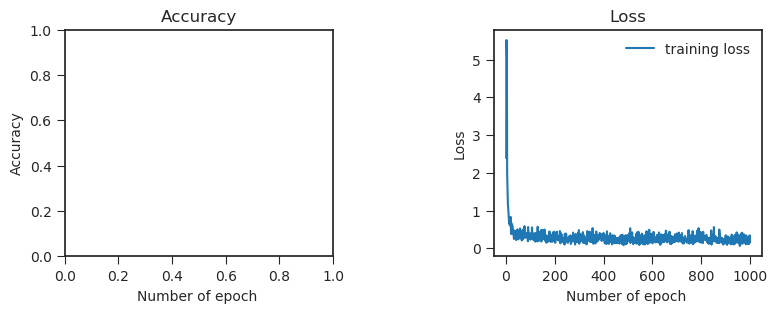

In [71]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss_1'][0],history_train['loss_1'][1])

### Train and evaluate the  keras to estimator model locally

In [41]:
%%time
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)
# need if file are removed with previous event files
tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=True)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
using keras model in estimator
keras_baseline_model
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c447c0978>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c48c59be0>, '_task_type': 'work

INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:22:43
INFO:tensorflow:Saving dict for global step 40: accuracy = 0.9118, global_step = 40, loss = 0.2962111
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 40: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-40
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-90
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704579'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 100 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:23:01
INFO:te

INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-140
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704598'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 150 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:23:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:23:23
INFO:tensorflow:Saving dict for global step 150: accuracy = 0.9337, global_step = 150, loss = 0.2

INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:23:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:23:44
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.9344, global_step = 200, loss = 0.22008936
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_defau

INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:23:59
INFO:tensorflow:Saving dict for global step 250: accuracy = 0.9384, global_step = 250, loss = 0.20468895
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-250
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-250
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/expo

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-300
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704653'/saved_model.pb
INFO:tensorflow:global_step/sec: 3.39079
INFO:tensorflow:loss = 0.23021457, step = 300 (14.746 sec)
INFO:tensorflow:Saving checkpoints for 310 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704669'/saved_model.pb
INFO:tensorflow:global_step/sec: 3.11826
INFO:tensorflow:loss = 0.2029829, step = 350 (16.035 sec)
INFO:tensorflow:Saving checkpoints for 360 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:24:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-360
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:24:32
INFO:tensorflow:Saving dict for global step 360: accuracy = 0.9445, global_step = 360, loss = 0.190

INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:24:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-410
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:24:49
INFO:tensorflow:Saving dict for global step 410: accuracy = 0.9531, global_step = 410, loss = 0.16222641
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 410: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-410
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_defau

INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:25:02
INFO:tensorflow:Saving dict for global step 460: accuracy = 0.9483, global_step = 460, loss = 0.18424188
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 460: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-460
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-460
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/expo

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-510
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704715'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 520 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:25:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704727'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 570 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:25:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-570
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:25:30
INFO:tensorflow:Saving dict for global step 570: accuracy = 0.9458, global_step = 570, loss = 0.18963115
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 570: results/Models/Mnist/tf

INFO:tensorflow:Starting evaluation at 2019-04-08-06:25:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:25:42
INFO:tensorflow:Saving dict for global step 620: accuracy = 0.948, global_step = 620, loss = 0.18327785
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 620: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-620
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Ev

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 670: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-670
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-670
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704755'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 680 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tens

INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-720
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704771'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 730 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:26:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-730
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluati

INFO:tensorflow:Saving checkpoints for 780 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:26:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-780
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:26:28
INFO:tensorflow:Saving dict for global step 780: accuracy = 0.9512, global_step = 780, loss = 0.16740596
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 780: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-780
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDE

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:26:42
INFO:tensorflow:Saving dict for global step 830: accuracy = 0.9538, global_step = 830, loss = 0.16706364
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 830: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-830
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-830
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensor

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-880
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704815'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 890 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:26:56
INFO:t

INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-930
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554704829'/saved_model.pb
INFO:tensorflow:Saving checkpoints for 940 into results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt.
INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:27:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-940
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:27:11
INFO:tensorflow:Saving dict for global step 940: accuracy = 0.9589, global_step = 940, loss = 0.1

INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-06:27:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-990
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-06:27:26
INFO:tensorflow:Saving dict for global step 990: accuracy = 0.9543, global_step = 990, loss = 0.1719148
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 990: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-990
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_defaul

### Visualize the keras to estimator model train/eval

INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554704548.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1554704553.Fabien-Tarrades-MacBook-Pro.local


keras
checkpoint
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.meta
model.ckpt-990.index
graph.pbtxt
model.ckpt-990.data-00000-of-00001
model.ckpt-980.meta
events.out.tfevents.1554704548.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-990.meta
eval
model.ckpt-980.data-00000-of-00001
export
model.ckpt-980.index
model.ckpt-1000.index


dict_keys(['global_step/sec', 'loss_1'])
dict_keys(['accuracy', 'loss'])
number of entry for train: 2
number of entry for eval: 100




Loss:
  - loss [training dataset]: 0.212
  - loss [validation dataset: 0.189

Accuracy:
  - accuracy [validation dataset: 95.04%


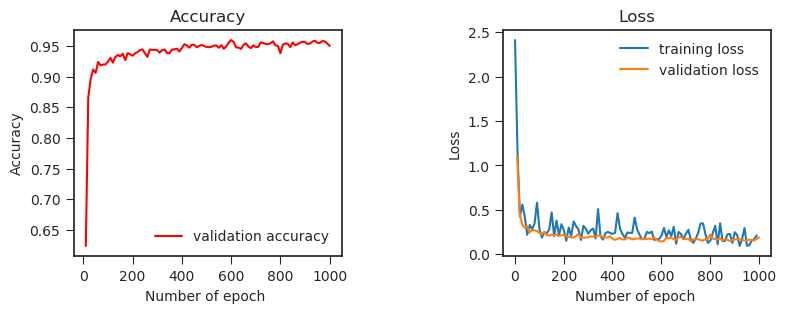

In [42]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss_1']))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss_1'][0],history_train['loss_1'][1],
                       None, None,
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Predict using the  keras to estimator model locally

### Train and evaluate the estimator model with keras layers locally

In [45]:
%%time
tf.logging.set_verbosity(tf.logging.DEBUG)
# Delete both saved and checkpointed models
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)
for x in glob.glob(FLAGS.model_dir+'*') :
    print(x)
# need if file are removed with previous event files
tf.summary.FileWriterCache.clear()
# Reset Keras
tf.keras.backend.clear_session()
# Fit the model (using estimator.train and data.Dataset)
mnist_v1.train_and_evaluate(FLAGS, use_keras=False)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
using keras layer and estimator
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c49921da0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c49921710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_eva

INFO:tensorflow:input_dataset_fn: EVAL, eval
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-08-08:02:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-04-08-08:02:04
INFO:tensorflow:Saving dict for global step 50: accuracy = 0.098, global_step = 50, loss = 2.3630993
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 50: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-50
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
IN

INFO:tensorflow:Saving dict for global step 100: accuracy = 0.098, global_step = 100, loss = 2.3630993
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-100
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/temp-b'1554710539'/saved_model.pb
INFO:tensorflow:global_step/sec: 3.51315
INFO:tensorflo

KeyboardInterrupt: 

### Visualize the estimator model with keras layers locally

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554704869.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554704869.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554704869.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1554704869.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1554704873.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1554704873.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

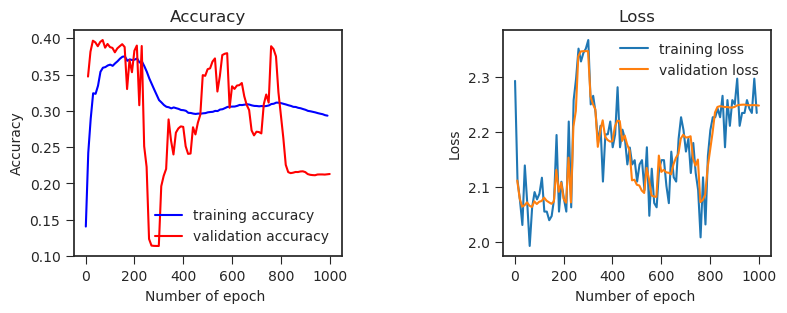

In [44]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train and evaluate the estimator model with keras layers locally with python
do a small test locally to check that the python package is working

In [103]:
%%bash
# Setup python so it sees the task module which controls the model.py
export PYTHONPATH=${PYTHONPATH}:${PWD}/src/model_mnist_v1
python -m trainer.task \
--epoch=2 \
--step_per_epoch=468 \
--input_test_tfrecords='data/mnist/tfrecords_image_test/*' \
--input_train_tfrecords='data/mnist/tfrecords_image_train/*' \
--model_dir='results/Models/Mnist/tf_1_12/estimator/ckpt/' \
--saved_dir='results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c39505898>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using config: {'_model_dir': 'results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 50, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0x1c39505be0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c39505da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief'

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553682141.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553682145.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

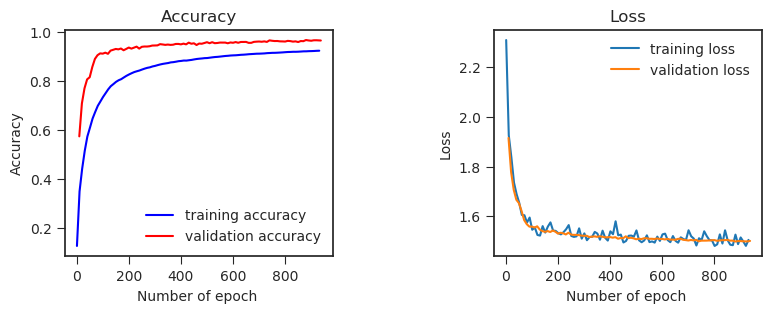

In [104]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on locally using gcloud

In [109]:
%%bash
# Use Cloud Machine Learning Engine to train the model in local file system
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords=${PWD}/'data/mnist/tfrecords_image_test/*' \
   --input_train_tfrecords=${PWD}/'data/mnist/tfrecords_image_train/*' \
   --model_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/ckpt/' \
   --saved_dir=${PWD}/'results/Models/Mnist/tf_1_12/estimator/pt/' 

exporter <tensorflow.python.estimator.exporter.LatestExporter object at 0x1c32505668>
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 1 2
not training 

INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'cluster': {}, 'job': {'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_test/*', '--input_train_tfrecords=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/mnist/tfrecords_image_train/*', '--model_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/ckpt/', '--saved_dir=/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/'], 'job_name': 'trainer.task'}, 'task': {}}
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:RunConfig initialized for Distribute Coordinator with INDEPENDENT_WORKER mode
INFO:

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553686740.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt//eval/events.out.tfevents.1553686744.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tens

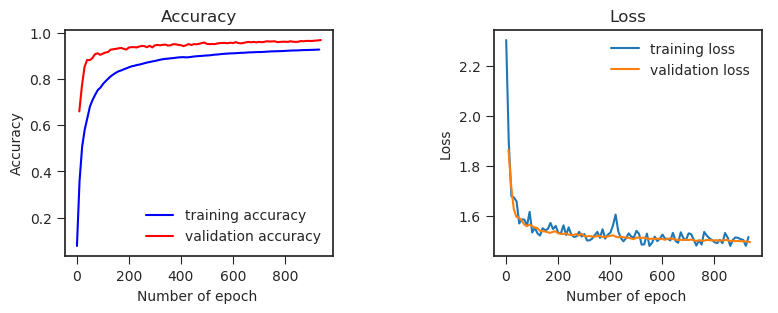

In [110]:
debug=True
history_train=ml_utils.load_data_tensorboard(FLAGS.model_dir)
history_eval=ml_utils.load_data_tensorboard(FLAGS.model_dir+'/eval')
if debug:
    print('\n')
    for file in glob.glob(FLAGS.model_dir+'*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print(history_eval.keys())
    print('number of entry for train:', len(history_train['loss'][0]))
    print('number of entry for eval:', len(history_eval['loss'][0]))
print('\n\n\n')
ml_utils.plot_acc_loss(history_train['loss'][0],history_train['loss'][1],
                       history_train['accuracy_1'][0],history_train['accuracy_1'][1],
                       history_eval['loss'][0],history_eval['loss'][1],
                       history_eval['accuracy'][0],history_eval['accuracy'][1])

### Train the model on GCP using gcloud

In [630]:
!gsutil ls gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-9.tfrecords
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecord_image_test/
gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/tfrecords_image_test/


In [111]:
!pwd

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


In [653]:
%%bash
echo "gs://${PROJECT}/mnist/tfrecords/image_test/"

gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/


In [658]:
%%bash
# Clear Cloud Storage bucket and copy the tfrecords files to Cloud Storage bucket
echo $BUCKET
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m rm -rf "gs://${BUCKET}/mnist/tfrecords/image_train/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_test/*" "gs://${BUCKET}/mnist/tfrecords/image_test/"
gsutil -m cp "${PWD}/data/mnist/tfrecords_image_train/*" "gs://${BUCKET}/mnist/tfrecords/image_train/"

ml-productive-pipeline-53122


Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-1.tfrecords#1553517828053883...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-10.tfrecords#1553517828015615...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-2.tfrecords#1553517827285785...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-3.tfrecords#1553517827539125...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-4.tfrecords#1553517828118894...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-5.tfrecords#1553517827486017...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-6.tfrecords#1553517827901783...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-7.tfrecords#1553517828044041...
Removing gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/test-8.tfrecords#1553517827140683...
Removing gs://ml-productive-pipeline

In [696]:
%%bash
OUTDIR="gs://${BUCKET}/${MODEL_NAME}/${TRAINING_DIR}"
JOBNAME=${MODEL_NAME}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
# Clear the Cloud Storage Bucket used for the training job
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/src/${MODEL_NAME}/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket="gs://$BUCKET" \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   --python-version='3.5' \
   --labels=$RESOURCE_LABELS \
   -- \
   --epoch=2 \
   --step_per_epoch=468 \
   --input_test_tfrecords= "gs://${BUCKET}/mnist/tfrecords/image_test/*" \
   --input_train_tfrecords="gs://${BUCKET}/mnist/tfrecords/image_train/*" \
   --model_dir=$OUTDIR \
   --saved_dir=$OUTDIR   

gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained us-central1 model_mnist_v1_190325_152158
jobId: model_mnist_v1_190325_152158
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [model_mnist_v1_190325_152158] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe model_mnist_v1_190325_152158

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158


In [697]:
! gcloud ml-engine jobs stream-logs model_mnist_v1_190325_152158

INFO	2019-03-25 16:22:04 +0100	service		Validating job requirements...
INFO	2019-03-25 16:22:04 +0100	service		Job creation request has been successfully validated.
INFO	2019-03-25 16:22:05 +0100	service		Job model_mnist_v1_190325_152158 is queued.
INFO	2019-03-25 16:22:05 +0100	service		Waiting for job to be provisioned.
INFO	2019-03-25 16:22:08 +0100	service		Waiting for training program to start.
INFO	2019-03-25 16:23:44 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz"],  "python_module": "trainer.task",  "args": ["--epoch\u003d2", "--step_per_epoch\u003d468", "--input_test_tfrecords\u003d", "gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*", "--input_train_tfrecords\u003dgs://ml-productive-pipeline-53122/mni

INFO	2019-03-25 16:24:28 +0100	master-replica-0		TF_CONFIG environment variable: {'task': {'cloud': 'qe913eccfb8ab063b-ml', 'index': 0, 'type': 'master'}, 'cluster': {'master': ['127.0.0.1:2222']}, 'environment': 'cloud', 'job': {'runtime_version': '1.12', 'python_module': 'trainer.task', 'package_uris': ['gs://ml-productive-pipeline-53122/model_mnist_v1_190325_152158/c22fca2b0adcf8de1bb4a11353a9ac9cc2f655f4d527462ea4346efc2e3e7a11/model_mnist_v1-0.1.tar.gz'], 'python_version': '3.5', 'job_dir': 'gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', 'region': 'us-central1', 'run_on_raw_vm': True, 'args': ['--epoch=2', '--step_per_epoch=468', '--input_test_tfrecords=', 'gs://ml-productive-pipeline-53122/mnist/tfrecords/image_test/*', '--input_train_tfrecords=gs://ml-productive-pipeline-53122/mnist/tfrecords/image_train/*', '--model_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained', '--saved_dir=gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained',

INFO	2019-03-25 16:25:09 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:25:09 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:25:15 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527507'/saved_model.pb
INFO	2019-03-25 16:25:19 +0100	master-replica-0		Saving checkpoints for 40 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:25:26
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:25:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/mo

INFO	2019-03-25 16:26:26 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-100
INFO	2019-03-25 16:26:26 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:26:26 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:26:31 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527585'/saved_model.pb
INFO	2019-03-25 16:26:34 +0100	master-replica-0		global_step/sec: 1.00519
INFO	2019-03-25 16:26:34 +0100	master-replica-0		loss = 0.31793758, step = 100 (99.484 sec)
INFO	2019-03-25 16:26:34 +0100	master-replica-0		Saving checkpoints for 120 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:26:41 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:26:41

INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-180
INFO	2019-03-25 16:27:40 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:27:40 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:27:45 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527658'/saved_model.pb
INFO	2019-03-25 16:27:48 

INFO	2019-03-25 16:28:46 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:28:46
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:28:46 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:28:47
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving dict for global step 260: accuracy = 0.0, global_step = 260, loss = 0.0
INFO	2019-03-25 16:28:47 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 260: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-260
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:28:48 +0100	master-replica-0		Done calling model_

INFO	2019-03-25 16:29:54 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:29:54
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving dict for global step 340: accuracy = 0.0, global_step = 340, loss = 0.0
INFO	2019-03-25 16:29:54 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 340: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-340
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:29:55 +0100	master-replica-0		Signatures INCLUDED in export 

INFO	2019-03-25 16:30:48 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527844'/saved_model.pb
INFO	2019-03-25 16:30:51 +0100	master-replica-0		global_step/sec: 1.22815
INFO	2019-03-25 16:30:51 +0100	master-replica-0		loss = 0.047065996, step = 400 (81.423 sec)
INFO	2019-03-25 16:30:51 +0100	master-replica-0		Saving checkpoints for 420 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:30:57 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:30:57
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:30:58 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/mode

INFO	2019-03-25 16:31:54 +0100	master-replica-0		Saving checkpoints for 500 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:32:00 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Starting evaluation at 2019-03-25-15:32:01
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Graph was finalized.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-500
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:32:01 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:32:02
INFO	2019-03-25 16:32:02 +0100	master-replica-0		Saving dict for global

INFO	2019-03-25 16:32:49 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:32:53 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527968'/saved_model.pb
INFO	2019-03-25 16:32:56 +0100	master-replica-0		Saving checkpoints for 580 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:08 +0100	master-replica-0		SavedModel written to: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/export/exporter/temp-b'1553527984'/saved_model.pb
INFO	2019-03-25 16:33:11 +0100	master-replica-0		Saving checkpoints for 600 into gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		input_dataset_fn: EVAL, eval
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:33:17 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:33:17 +0100	m

INFO	2019-03-25 16:34:02 +0100	master-replica-0		Saving dict for global step 660: accuracy = 0.0, global_step = 660, loss = 0.0
INFO	2019-03-25 16:34:05 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 660: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-660
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:34:06 +0100	master-replica-0		Restori

INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving dict for global step 740: accuracy = 0.0, global_step = 740, loss = 0.0
INFO	2019-03-25 16:35:04 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 740: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-740
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:35:05 +0100	master-replica-0		Restori

INFO	2019-03-25 16:36:02 +0100	master-replica-0		Running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Done running local_init_op.
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Finished evaluation at 2019-03-25-15:36:02
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving dict for global step 820: accuracy = 0.0, global_step = 820, loss = 0.0
INFO	2019-03-25 16:36:02 +0100	master-replica-0		Saving 'checkpoint_path' summary for global step 820: gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-820
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:36:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	20

INFO	2019-03-25 16:37:03 +0100	master-replica-0		Calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Done calling model_fn.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['serving_default']
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Classify: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Train: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Signatures INCLUDED in export for Regress: None
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/model_mnist_v1/mnist_trained/model.ckpt-900
INFO	2019-03-25 16:37:03 +0100	master-replica-0		Assets added to graph.
INFO	2019-03-25 16:37:03 +0100	master-replica-0		No assets to write.
INFO	2019-03-25 16:37:08 +0100	master-replica-0		SavedModel written to:

INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-03-25 16:37:42 +0100	master-replica-0		not training 1 2
INFO	2019-

## Visualization

In [ ]:
#for e in tf.train.summary_iterator('/tmp/mnist_convnet_model/events.out.tfevents.1553025053.Fabien-Tarrades-MacBook-Pro.local'):
for e in tf.train.summary_iterator('results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local'):
    for v in e.summary.value:
        #if v.tag == 'accuracy':
        #print(v.simple_value)
        print(v)

In [736]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

def load_data_tensorboard(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}
    
    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []
        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)
        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [739]:
#history_eval=load_data_tensorboard(FLAGS.model_dir+'/eval')
history_train=load_data_tensorboard(FLAGS.model_dir)

DEBUG:tensorflow:Opening a record reader pointing at results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Loading events from results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
DEBUG:tensorflow:Cannot read more events: Read less bytes than requested
DEBUG:tensorflow:No more events in results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local
INFO:tensorflow:No path found after results/Models/Mnist/tf_1_12/estimator/ckpt/events.out.tfevents.1553604823.Fabien-Tarrades-MacBook-Pro.local


In [740]:
history_eval.keys(), history_train.keys()

(dict_keys(['accuracy', 'loss']), dict_keys(['global_step/sec', 'loss_1']))

In [574]:
len(history_train['accuracy_1'][1]), len(history_eval['accuracy'][1]), len(history_train['global_step/sec'][1])

(100, 100, 19)

In [575]:
history_eval['accuracy'][0]

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [741]:
history_train['accuracy_1'][0]

KeyError: 'accuracy_1'

Loss:
  - loss [training dataset]: 1.526
  - loss [validation dataset: 1.496

Accuracy:
  - accuracy [training dataset]: 92.73%
  - accuracy [validation dataset: 96.68%


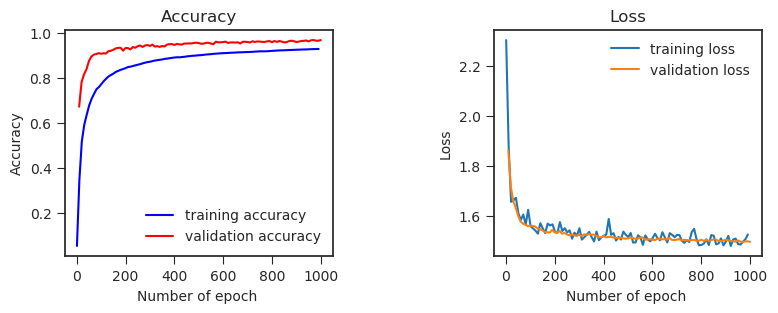

In [577]:
# plot the training loss and accuracy
fig = plt.figure(figsize=(9, 3), dpi=100)
plt.subplots_adjust(wspace=0.6)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(history_train['accuracy_1'][0], history_train['accuracy_1'][1], 'b', label='training accuracy')
ax1.plot(history_eval['accuracy'][0], history_eval['accuracy'][1], 'r', label='validation accuracy');
ax1.set_title('Accuracy')
ax1.set_xlabel("Number of epoch ")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="best")

ax2.plot(history_train['loss'][0], history_train['loss'][1], label="training loss")
ax2.plot(history_eval['loss'][0], history_eval['loss'][1], label="validation loss")
ax2.set_title("Loss")
ax2.set_xlabel("Number of epoch ")
ax2.set_ylabel("Loss")
ax2.legend(loc="best");

print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(history_train['loss'][1][-1]))
print('  - loss [validation dataset: {0:.3f}'.format(history_eval['loss'][1][-1]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100 * history_train['accuracy_1'][1][-1]))
print('  - accuracy [validation dataset: {:.2f}%'.format(100 * history_eval['accuracy'][1][-1]))

### Check the output created during the training
https://medium.com/@prasadpal107/saving-freezing-optimizing-for-inference-restoring-of-tensorflow-models-b4146deb21b5  
- creating a keras model will create the **keras** folder 
- **checkpoint**, text file that contain all checkpoint information, like model ckpt file name and path
- **model.ckpt-xxx.meta** and **model.ckpt-xxx.data-yyyyy-of-zzzzz** and **model.ckpt-xxx.index** file created for each model  
  .ckpt-xxx.meta contains the complete graph. It includes GraphDef, SaverDef, and so on  
  .ckpt-xxx.data contains the values of variables(weights, biases, placeholders, gradients, hyper-parameters etc)   
  .ckpt-xxx.index is a table where each key is the name of a tensor and its value is a serialized BundleEntryProto 
- **graph.pbtxt** holds a network of nodes, each representing one operation, connected to each other as inputs and outputs (graph structure)
- **events.out.tfevents.xxxxxxxxxx** which contain information that TensorBoard uses to create visualizations

Meta files holds ,more than just the structure of the graph like MetaInfoDef , GraphDef SaverDef , CollectionDef . Whereas .pbtxt files holds only the structure of the graph.

In [100]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
checkpoint
model.ckpt-940.data-00000-of-00001
model.ckpt-1000.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-940.meta
model.ckpt-1000.meta
model.ckpt-960.meta
events.out.tfevents.1552739145.Fabien-Tarrades-MacBook-Pro.local
graph.pbtxt
model.ckpt-980.meta
model.ckpt-960.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
eval
model.ckpt-980.data-00000-of-00001
export
model.ckpt-960.index
model.ckpt-980.index
model.ckpt-940.index
model.ckpt-1000.index


### TensorBoard

In [39]:
print('Tensorflow logs will be saved here:\n',FLAGS.model_dir)

Tensorflow logs will be saved here:
 results/Models/Mnist/tf_1_12/estimator/ckpt/


In [243]:
for file in glob.glob(FLAGS.model_dir+'*events.out.tfevents.*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1553024123.Fabien-Tarrades-MacBook-Pro.local


In [228]:
tensorboard_command='tensorboard --logdir "'+FLAGS.model_dir+'"'

In [42]:
print('In a separate shell with the same env activated (need Tensoflow and TensorBoard)')
print('  copy and pate the command below without ">>":')
print('  >>',tensorboard_command)


In a separate shell with the same env activated (need Tensoflow and TensorBoard)
  copy and pate the command below without ">>":
  >> tensorboard --logdir "results/Models/Mnist/tf_1_12/estimator/ckpt/"


### Looking at the output of the TimeHistory

In [ ]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

In [ ]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

## Accuracy and losses

### Training dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_train_tfrecords+'/train*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.TRAIN,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [training dataset]: {}'.format(score['global_step']))

### Testing dataset

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(glob.glob(path_test_tfrecords+'/test*.tfrecords'),
                                                                                              FLAGS,
                                                                                              mode=tf.estimator.ModeKeys.EVAL,
                                                                                              batch_size=FLAGS.batch_size),
                                     steps=1)

In [ ]:
# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score['loss']))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score['accuracy']))
print('')
print('Number of steps:')
print('  - number of steps [testing dataset]: {}'.format(score['global_step']))

## Test

In [ ]:
# Rebuild the model
predictions = model_fn(features, labels, tf.estimator.ModeKeys.EVAL).predictions

# Manually load the latest checkpoint
saver = tf.train.Saver()
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state('/my/directory')
    saver.restore(sess, ckpt.model_checkpoint_path)

    # Loop through the batches and store predictions and labels
    prediction_values = []
    label_values = []
    while True:
        try:
            preds, lbls = sess.run([predictions, labels])
            prediction_values += preds
            label_values += lbls
        except tf.errors.OutOfRangeError:
            break
    # store prediction_values and label_values somewhere

## Prediction 

### Method 1

In [ ]:
testing_dataset = mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                           FLAGS,
                                                           mode=tf.estimator.ModeKeys.EVAL)

In [ ]:
iterator = testing_dataset.make_one_shot_iterator()
# next_element
features, labels = iterator.get_next()

In [ ]:
n=0

n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

In [ ]:
predictions=list(estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.PREDICT)))

In [ ]:
len(predictions), len(x_test)

In [ ]:
output_layer=model_opt_tf.output_names[0]

In [ ]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)

### Method 2

In [ ]:
preds_iter=estimator_train_model.predict(input_fn=lambda:mnist_v1.input_mnist_tfrecord_dataset_fn(sorted(glob.glob(path_test_tfrecords+'/test*.tfrecords'), key=os.path.getmtime),
                                                                                                  FLAGS,
                                                                                                  mode=tf.estimator.ModeKeys.EVAL,
                                                                                                  batch_size=len(x_test)))

In [ ]:
i=0
for pred in list(itertools.islice(preds_iter, 5)):
    prediction_array = pred['dense_2']
    predicted_label = np.argmax(prediction_array)
    print(prediction_array)
    print(i)
    if i==0:
        print('--> ',pred.keys())
    print()
    print('Actual label:', y_test[i])
    print("Predicted label: ", predicted_label)
    i+=1

### Keras's model checks

In [ ]:
model_opt_tf.summary()

In [ ]:
model_opt_tf.input_names

In [ ]:
model_opt_tf.output_names

In [ ]:
output_layer=model_opt_tf.output_names[0]

### Estimator's model checks

In [ ]:
estimator_train_model.get_variable_names()

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

In [ ]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

In [ ]:
estimator_train_model.latest_checkpoint()

## Model serving using Keras, tf.estimator and tf.data.dataset

In [ ]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

In [ ]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [ ]:
model_opt_tf.input_names

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [ ]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

In [495]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [504]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']='results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141'#FLAGS.saved_dir+model_tag+'/'

In [502]:
!ls results/Models/Mnist/tf_1_12/estimator/ckpt/export/exporter/1553112141

saved_model.pb variables


In [ ]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

## Check the saved model before serving 

In [493]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [505]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: ArgMax:0
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [ ]:
input_prediction=x_test[0:3]

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [ ]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [ ]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [ ]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [ ]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [ ]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [ ]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['PROJECT']
os.environ['VERSION']='v2'

In [ ]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [ ]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

In [ ]:
!gcloud ml-engine models list

when creating the model for the first time

create a version and store the model

In [ ]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

#### Checking the list of model in ML-Engine

In [ ]:
!gcloud ml-engine models list

In [ ]:
 !gcloud ml-engine versions list --model mnist

#### Testing our model using ML-Engine

In [ ]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [ ]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

In [ ]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

Use python and requests

In [ ]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))
}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [ ]:
# to do

## Debug Python environment

In [ ]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

In [ ]:
!conda list

In [ ]:
## Reload the model and make evaluation using Keras

In [ ]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [ ]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
### Evaluate the model using Keras and tf.data.dataset

In [ ]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))